In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
)


matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

In [2]:
def getdata():
    data = pd.read_csv("feature_vectors.csv").to_numpy()
    labels = pd.read_csv("diagnosis_label.csv").to_numpy().squeeze()
    labelscenter = pd.read_csv("center_label.csv").to_numpy().squeeze()

    labelsfinal = labels + labelscenter
    
    # better way to perform this
    labelsdiseases1 = np.where(labelsfinal == 'HCUMCG') 
    centerlabels1 = labelsfinal[labelsdiseases1]
    labelsdiseases2 = np.where(labelsfinal == 'HCUGOSM') 
    #labelsdiseases = np.where(labels == 'HCCUN','1',centerlabels) 
    centerlabels2 = labelsfinal[labelsdiseases2]
    labelsdiseases3 = np.where(labelsfinal == 'HCCUN') 
    centerlabels3 = labelsfinal[labelsdiseases3]
    
    # better way to perform this
    centerlabels = np.concatenate((centerlabels1,centerlabels2,centerlabels3))
    centerdata = data[labelsdiseases1]
    centerdata = np.concatenate((centerdata,data[labelsdiseases2]))
    centerdata = np.concatenate((centerdata,data[labelsdiseases3]))
    
    
    #data = ztransform(data)
    #centerdata = ztransform(centerdata)
    return data,labels,centerdata,centerlabels

In [3]:
def ztransform(data_ztransform):
    # Sklearn's standardscaler to perform z-transform
    scaler = StandardScaler()

    # Compute (fit) and apply (transform) z-transform
    # why do we do an inverse z transform
    data_ztransform = scaler.fit_transform(data_ztransform)
    
    return data_ztransform

In [4]:
def model_definition():
    
    model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
    solver_type="sgd",
    solver_params={"max_runs": 20,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,)
    
    return model

In [5]:
def train_modelkfold(data, label, folds=10):
    modellist = list()
    accuracies = list()
    x_dlist = list()
    y_dlist = list()
    transformed_modell = list()
    transformed_datal = list()
    scaler = StandardScaler()

    kfold = KFold(folds, shuffle=True,random_state=3)
    for training_indices, testing_indices in kfold.split(data):
        model = model_definition()
        accuracy = 0
        correct = 0
        trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
        print(np.shape(trainX))
        model.fit(trainX, trainY)
        
        #validation accuracy
        # could use model.predict but it will only give the fraction of the correctly predicted labels
        #_, accuraccy = model.evaluate(testX, testY)
        predictedlabels = model.predict(testX)
        
        # since no model.evaluate.....
        
        for i in range(len(predictedlabels)):
            if(predictedlabels[i]==testY[i]):
                correct = correct+1
        
        accuracy = correct/len(testY)
        print('%.3f accuracy' % (correct/len(testY)))
        
        
        # tranforming the data in every k fold iteration on that specific 
        trainX = scaler.fit_transform(trainX)
        trainX = scaler.inverse_transform(trainX)
        transformed_data = model.transform(trainX, scale=True)

        x_d = transformed_data[:, 0]
        y_d = transformed_data[:, 1]

        # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
        # prototype inverser transform
        prototypes = scaler.inverse_transform(model.prototypes_)
        transformed_model = model.transform(prototypes, scale=True)
        
        
        
        # stores accuracies and test data on last kth model
        accuracies.append(accuracy)
        modellist.append(model)
        
        x_dlist.append(x_d)
        y_dlist.append(y_d)
        transformed_modell.append(transformed_model)
        transformed_datal.append(transformed_data)
        print('======================================')
        print(confusion_matrix(testY, predictedlabels))
        print('======================================')
        #histories.append(history_kfold)
    return modellist,accuracies,x_dlist,y_dlist,transformed_modell,transformed_datal

In [6]:
def calculate_lambda():
    #average_lambda = np.mean(sum(model.lambda_ for model in modellist),axis=0)
    average_lambda = sum(model.lambda_ for model in modellist)/len(modellist)
        #modellist
    return average_lambda

In [7]:
#def averageplot(x_list,y_list,transformed_modell):
#    xlist= sum(x for x in x_list)/len(x_list)
#    ylist=sum(y for y in y_list)/len(y_list)

    # column eigen vectors
    
#    transformlist=sum((transformed for transformed in transformed_modell), axis = 1)/len(ylist)
    
#    return xlist,ylist,transformlist

In [8]:
data,labels,centerdata,centerlabels = getdata()
modellist,accuracies,x_dlist,y_dlist,transformed_modell,transformed_datal = train_modelkfold(centerdata,centerlabels)

(73, 36)
0.889 accuracy
[[2 0 0]
 [0 1 1]
 [0 0 5]]
(73, 36)
0.889 accuracy
[[8 1]
 [0 0]]
(74, 36)
1.000 accuracy
[[3 0 0]
 [0 4 0]
 [0 0 1]]
(74, 36)
1.000 accuracy
[[3 0 0]
 [0 2 0]
 [0 0 3]]
(74, 36)
1.000 accuracy
[[2 0 0]
 [0 5 0]
 [0 0 1]]
(74, 36)
0.875 accuracy
[[3 0 0]
 [0 4 0]
 [0 1 0]]
(74, 36)
0.750 accuracy
[[1 0 0]
 [0 5 0]
 [0 2 0]]
(74, 36)
1.000 accuracy
[[2 0 0]
 [0 4 0]
 [0 0 2]]
(74, 36)
0.875 accuracy
[[1 0 0]
 [0 5 0]
 [0 1 1]]
(74, 36)
0.875 accuracy
[[2 0 0]
 [0 4 0]
 [0 1 1]]


In [9]:
np.diagonal(modellist[9].lambda_)

array([6.92334080e-04, 1.82993093e-04, 1.50674635e-03, 9.66910900e-04,
       7.45194157e-02, 3.49536107e-02, 4.68415704e-03, 3.07042009e-02,
       1.08512547e-02, 2.00794308e-01, 3.94631294e-05, 1.79470281e-03,
       2.36713769e-02, 1.00125674e-03, 1.47842874e-02, 1.05838297e-02,
       1.47088586e-01, 5.43477534e-04, 1.85370104e-02, 1.01132822e-02,
       9.51579521e-02, 1.79634298e-03, 3.02717101e-03, 1.17000864e-02,
       6.24563840e-03, 2.23358851e-03, 4.27561658e-03, 2.28248751e-04,
       3.88279708e-02, 2.39812602e-02, 3.62343177e-03, 2.13196054e-02,
       1.30628036e-02, 3.10828582e-02, 1.55158746e-01, 2.65475337e-04])

In [10]:
np.shape(transformed_datal[9])

(74, 36)

In [11]:
len(x_dlist)

10

In [12]:
#xlist,ylist,transformlist = averageplot(x_dlist,y_dlist,transformed_modell)

In [13]:
average_lambda = calculate_lambda()

type(average_lambda)

# Eigen value decompostion of the average lambda to derive eigen values and eigen vectors

In [14]:
def eigendecomposition(average_lambda):
    eigenvalues, eigenvectors = np.linalg.eigh(average_lambda)
    # Flip (reverse the order to descending) before assigning.
    eigenvalues = np.flip(eigenvalues)

    # eigenvectors are column matrix in ascending order. Flip the columns and transpose the matrix
    # to get the descending ordered row matrix.
    eigenvectors = np.flip(eigenvectors, axis=1).T
    
    return eigenvalues,eigenvectors

In [15]:
eigenvalues,eigenvectors = eigendecomposition(average_lambda)

In [16]:
len(eigenvalues)

36

In [17]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


In [18]:
def ploteigenvalues(eigenvalues,eigenvectors):
   # Plot the eigenvalues of the eigenvectors of the relevance matrix.

    %matplotlib inline 
    fig, ax = plt.subplots()
    fig.suptitle("Eigenvalues")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    plt.savefig('centereigenvalues.png')


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    plt.savefig('Firstvectorcenter.png')

    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    plt.savefig('Secondvectorcenter.png')

    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal Center data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    plt.savefig('centerrelevance.png')


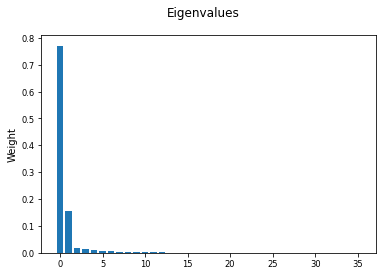

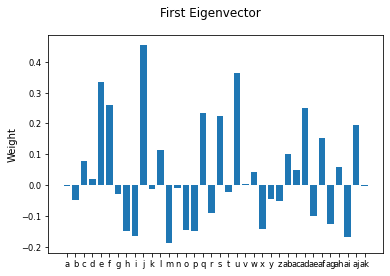

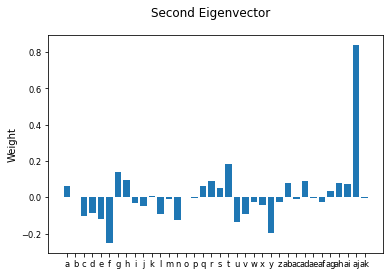

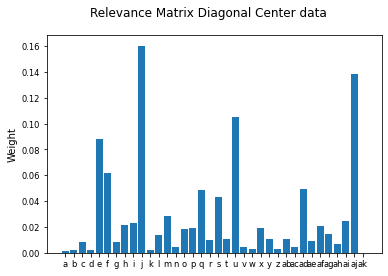

In [19]:
ploteigenvalues(eigenvalues,eigenvectors)

In [20]:
N=36
K=3
I = np.identity(N)
outerproduct = np.zeros((N,N))   
for i in range(K):
    
    outerproduct = np.outer(eigenvectors[i,:].T,eigenvectors[i,:])

correctionmatrix = I-outerproduct

In [21]:
len(correctionmatrix)

36

In [22]:
# Sklearn's standardscaler to perform z-transform
scaler = StandardScaler()

# Compute (fit) and apply (transform) z-transform
centerdata = scaler.fit_transform(centerdata)

# The creation of the model object used to fit the data to.
model1 = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
    solver_type="sgd",
    solver_params={"max_runs": 20,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,
    relevance_correction=correctionmatrix
)

In [23]:

# Train the model using the scaled data and true labels
model1.fit(data, labels)

# Predict the labels using the trained model
predicted_labels = model1.predict(data)
# To get a sense of the training performance we could print the classification report.
#print(classification_report(labelssubclass, predicted_labels))

In [24]:
# trained omega
omegad = model1.omega_

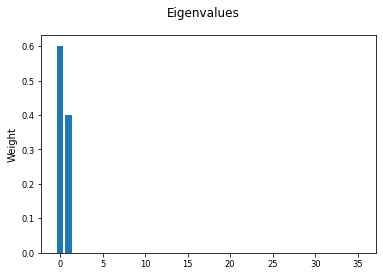

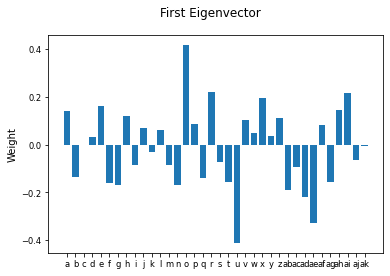

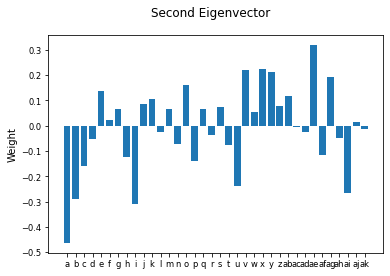

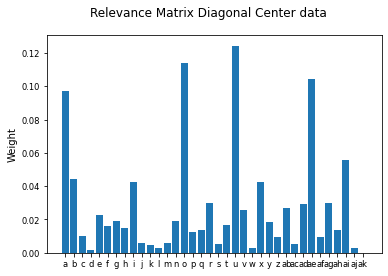

In [25]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
fig, ax = plt.subplots()
fig.suptitle("Eigenvalues")
ax.bar(range(0, len(model1.eigenvalues_)), model1.eigenvalues_)
ax.set_ylabel("Weight")
ax.grid(False)
plt.savefig('diseaseeigenvalues.png')


# Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
fig, ax = plt.subplots()
fig.suptitle("First Eigenvector")
ax.bar(feature_names, model1.omega_hat_[0, :])
ax.set_ylabel("Weight")
ax.grid(False)
plt.savefig('Firstvectordisease.png')


fig, ax = plt.subplots()
fig.suptitle("Second Eigenvector")
ax.bar(feature_names, model1.omega_hat_[1, :])
ax.set_ylabel("Weight")
ax.grid(False)
plt.savefig('Secondvectordisease.png')


fig, ax = plt.subplots()
# The relevance matrix is available after fitting the model.
relevance_matrix = model1.lambda_
fig.suptitle("Relevance Matrix Diagonal Center data")
ax.bar(feature_names, np.diagonal(relevance_matrix))
ax.set_ylabel("Weight")
ax.grid(False)
plt.savefig('disease123.png')

3
['AD' 'HC' 'PD']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


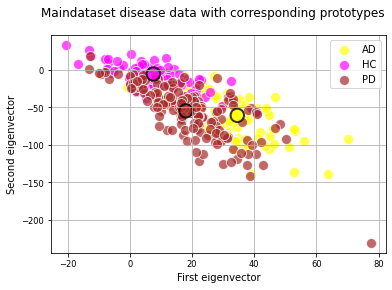

In [26]:
# removing the z transform
data = scaler.inverse_transform(data)
transformed_data = model1.transform(data, scale=True)

x_d = transformed_data[:, 0]
y_d = transformed_data[:, 1]

# Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
# prototype inverser transform
prototypes = scaler.inverse_transform(model1.prototypes_)

transformed_model1 = model1.transform(prototypes, scale=True)

print(len(model1.prototypes_))
x_m = transformed_model1[:, 0]
y_m = transformed_model1[:, 1]

fig, ax = plt.subplots()
fig.suptitle("Maindataset disease data with corresponding prototypes")
colors = ['yellow','Magenta','brown']#,'pink','lightgreen']
for i, cls in enumerate(model1.classes_):
    ii = cls == labels
    ax.scatter(
        x_d[ii],
        y_d[ii],
        c=colors[i],
        s=100,
        alpha=0.7,
        edgecolors="white",
        label=model1.classes_[model1.prototypes_labels_[i]],
    )
ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
ax.set_xlabel("First eigenvector")
ax.set_ylabel("Second eigenvector")
ax.legend()
ax.grid(True)
print(model1.classes_)
plt.savefig('disease.png')
#plt.savefig('destination_path23.eps', format='eps')
print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [10]:
print(modellist[1])

GMLVQ(activation_params={'beta': 2}, random_state=1428,
      solver_params={'batch_size': 1, 'max_runs': 20,
                     'step_size': array([0.1 , 0.05])},
      solver_type='sgd')
